## Procesamiento de imagenes GOES. Producto ABI-L2-ACHAF altura del tope de las nubes

En el notebook download_goesdata.ipynb están las rutinas para hacer una descarga, tomar las coordenadas lat/lon de la imagen y guardar todo en un xarray dataset. Todo eso usando el paquete "GOES" de python. 
Ya descargué algunas imagenes del 2022 a una frecuencia temporal de aproximadamente una imagen cada 10 minutos. En este notebook voy a estudiar esas imagenes y extraer series de tiempo de alta resolución en zonas de interés y evaluar como se ve el producto. 

In [228]:
#Importar librerias
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import geopandas as gpd
from glob import glob
import GOES
import os

coastline = gpd.read_file('/home/lucas/storage/VECTORIAL/South_America.shp')

In [235]:
#Procesar data cruda, recortar y agregar grilla lat/lon de la proyeccion geostacionaria
paths = glob('data/GOES/ABI-L2-ACHAF/*2022*[!SUBSAMPLE].nc')
for f in paths:
    if not os.path.isfile(f):
        print('Processing: ', f)
        pass
       # Open downloaded image and shrink domain
        data               = xr.open_dataset(f)
        x_attrs = data.x.attrs
        y_attrs = data.y.attrs

        x_attrs.pop('units')
        y_attrs.pop('units')

        data_attrs = data.attrs
        HT_attrs   = data.HT.attrs
        del data

        ds                 = GOES.open_dataset(f)
        domain             = [-90,-65,-50,-15]
        HT, LonCen, LatCen = ds.image('HT', lonlat='corner', domain=domain)

        lon,lat = LonCen.data, LatCen.data
        lon = np.diff(lon[1:,:])/2+lon[1:,1:]
        lat = np.diff(lat[1:,:])/2+lat[1:,1:]
        lon_attrs = {'units':'degrees_east','long_name':'Longitude of center of pixels','standard_name':'pixel center longitude'}
        lat_attrs = {'units':'degrees_north','long_name':'Latitude of center of pixels','standard_name':'pixel center latitude'}

        data = xr.Dataset(coords={'y':np.arange(lat.shape[0]), 'x':np.arange(lon.shape[1])})
        data.coords['lat'] = (('y','x'), lat)
        data.coords['lon'] = (('y','x'), lon)
        data['HT'] = (('y','x'), HT.data)

        data.lon.attrs = lon_attrs
        data.lat.attrs = lat_attrs
        data.x.attrs = x_attrs
        data.y.attrs = y_attrs
        data.HT.attrs=HT_attrs
        data.attrs = data_attrs
        data.to_netcdf(f.replace('.nc','_SUBSAMPLE.nc'))

In [16]:
#open data
paths = glob('data/GOES/ABI-L2-ACHAF/*2022*SUBSAMPLE*.nc')
times = [pd.to_datetime(p.split('_')[-2].replace('s','')) for p in paths]
data  = []
for p in paths:
    print(p)
    d = xr.open_dataset(p)
    data.append(d)
data = xr.concat(data, 'time') # concatenar todas las imagenes en el tiempo
data.coords['time'] = times
data = data.sortby('time')     # ordenar el tiempo ascendente
data.coords['time'] = data.time-pd.Timedelta(hours=4) #Cambiar a hora local
# data = data.reindex({'time':pd.date_range('2022-11-01','2022-12-01', freq='10min')}) #Tomar todas las fotos cada 10 minutos, si no hay meter un NaN


data/GOES/ABI-L2-ACHAF/OR_ABI-L2-ACHAF-M6_G16_s20221217T1410_SUBSAMPLE.nc
data/GOES/ABI-L2-ACHAF/OR_ABI-L2-ACHAF-M6_G16_s20221218T1110_SUBSAMPLE.nc
data/GOES/ABI-L2-ACHAF/OR_ABI-L2-ACHAF-M6_G16_s20221225T1940_SUBSAMPLE.nc
data/GOES/ABI-L2-ACHAF/OR_ABI-L2-ACHAF-M6_G16_s20221221T0110_SUBSAMPLE.nc
data/GOES/ABI-L2-ACHAF/OR_ABI-L2-ACHAF-M6_G16_s20221205T1150_SUBSAMPLE.nc
data/GOES/ABI-L2-ACHAF/OR_ABI-L2-ACHAF-M6_G16_s20221211T2350_SUBSAMPLE.nc
data/GOES/ABI-L2-ACHAF/OR_ABI-L2-ACHAF-M6_G16_s20221219T1810_SUBSAMPLE.nc
data/GOES/ABI-L2-ACHAF/OR_ABI-L2-ACHAF-M6_G16_s20221217T1150_SUBSAMPLE.nc
data/GOES/ABI-L2-ACHAF/OR_ABI-L2-ACHAF-M6_G16_s20221214T0200_SUBSAMPLE.nc
data/GOES/ABI-L2-ACHAF/OR_ABI-L2-ACHAF-M6_G16_s20221219T1510_SUBSAMPLE.nc
data/GOES/ABI-L2-ACHAF/OR_ABI-L2-ACHAF-M6_G16_s20221225T2320_SUBSAMPLE.nc
data/GOES/ABI-L2-ACHAF/OR_ABI-L2-ACHAF-M6_G16_s20221206T1440_SUBSAMPLE.nc
data/GOES/ABI-L2-ACHAF/OR_ABI-L2-ACHAF-M6_G16_s20221220T0850_SUBSAMPLE.nc
data/GOES/ABI-L2-ACHAF/OR_ABI-L2-ACHAF

Text(0, 0.5, '(m)')

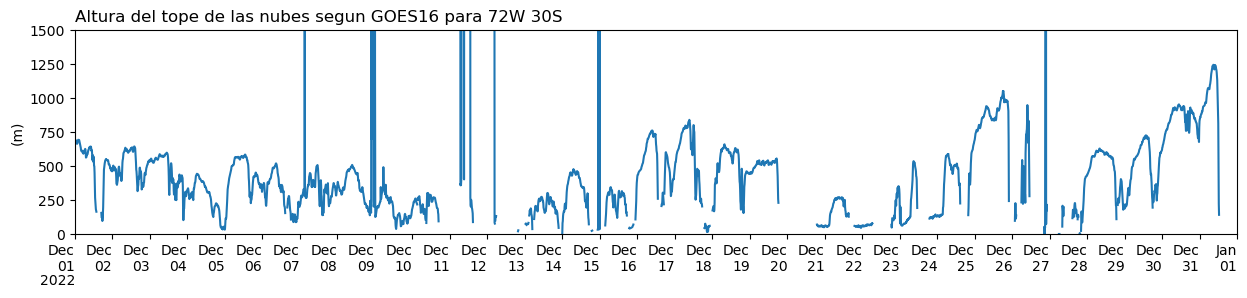

In [199]:
import matplotlib.dates as mdates
fig = plt.figure(figsize=(15,3))
ax  = fig.add_subplot(111)
data.sel(x=183, y=146).HT.to_series().plot(ax=ax)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%d'))
ax.tick_params(axis='x',rotation=0)
ax.set_xlim('2022-12-01','2023-01-01')
ax.text(-0.03,-0.25,'2022', transform=ax.transAxes)
ax.set_xlabel('')
ax.set_ylim(0,1500)
ax.set_title('Altura del tope de las nubes segun GOES16 para 72W 30S', loc='left')
ax.set_ylabel('(m)')

La figura anterior muestra una serie de tiempo de la altura del tope de las nubes segun el sensor GOES16 para el pixel mas cercano a las coordenadas 72W, 30S. De la serie se observa que en general la nubosidad es del tipo baja, alcanzando alturas no mayores a 1000m. Unos cuantos peaks muy grandes (ajuste el eje y) ocurren dentro de la serie, los cuales se interpretan como el paso de nubes cirrus o de mayor altura que no dejan al sensor ver la altura de las nubes bajas. Valores sin dato en la serie de tiempo se interpretan como situaciones donde no hay nube, es decir que está despejado. 

Dicho esto, con respecto a la nubosidad se observan varios días donde hay un crecimiento continuo de la altura de la capa de nubes consistente con el desarrollo de la capa límite diurna. Algunos ejemplos de dicha situación corresponden al 5, 14, 15, 24, 30 por dar algunos ejemplos. Otros días muestran capas nubosas semipermanentes durante varios días, como por ejemplo los días del 7 al 10 de diciembre. Dias 100% despejados parecen ser pocos durante este mes, aunque destacan los días del 11 al 13, donde sólo pasaron alguans nubes altas, o el día 20 y 22 donde estuvo despejado durante la tarde. 

Veamos como se ven los mapas de nubosidad en algunos de esos días interesantes...

Text(0.5, 1.1, 'Dia de mañana bien nublada')

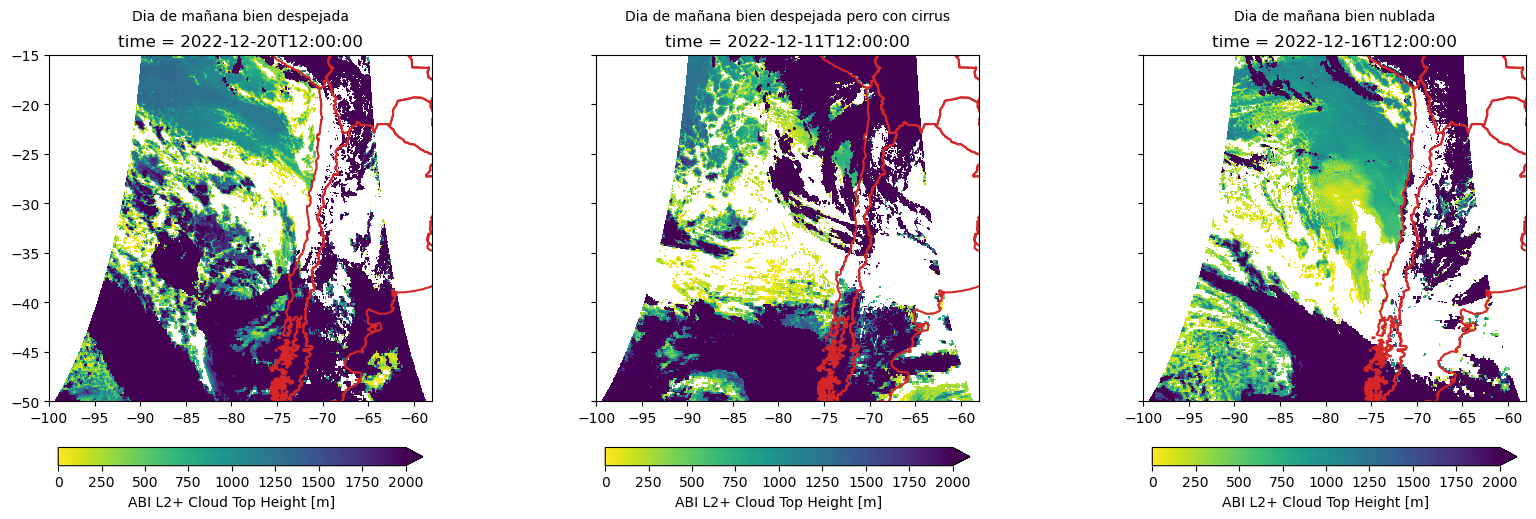

In [243]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,6))

cmap='viridis_r'
vmin,vmax=0,2000
data.sel(time="2022-12-20").HT[6*12].plot(y='lat',x='lon',vmin=vmin,vmax=vmax, cmap=cmap, ax=ax[0], cbar_kwargs={'orientation':'horizontal','pad':0.1, 'shrink':0.8}, add_labels=True)
data.sel(time="2022-12-11").HT[6*12].plot(y='lat',x='lon',vmin=vmin,vmax=vmax, cmap=cmap, ax=ax[1], cbar_kwargs={'orientation':'horizontal','pad':0.1, 'shrink':0.8}, add_labels=True)
data.sel(time="2022-12-16").HT[6*12].plot(y='lat',x='lon',vmin=vmin,vmax=vmax, cmap=cmap, ax=ax[2], cbar_kwargs={'orientation':'horizontal','pad':0.1, 'shrink':0.8}, add_labels=True)
for axis in ax.ravel():
    pass
    coastline.boundary.plot(ax=axis, color='tab:red')
    axis.set_xlim(-100,-58)
    axis.set_ylim(-50,-15)
    axis.set_ylabel('')
    axis.set_xlabel('')


ax[0].text(0.5,1.1,'Dia de mañana bien despejada', transform=ax[0].transAxes, ha='center')
ax[1].text(0.5,1.1,'Dia de mañana bien despejada pero con cirrus', transform=ax[1].transAxes, ha='center')
ax[2].text(0.5,1.1,'Dia de mañana bien nublada', transform=ax[2].transAxes, ha='center')

Text(0.5, 1.1, 'Dia de mañana bien nublada')

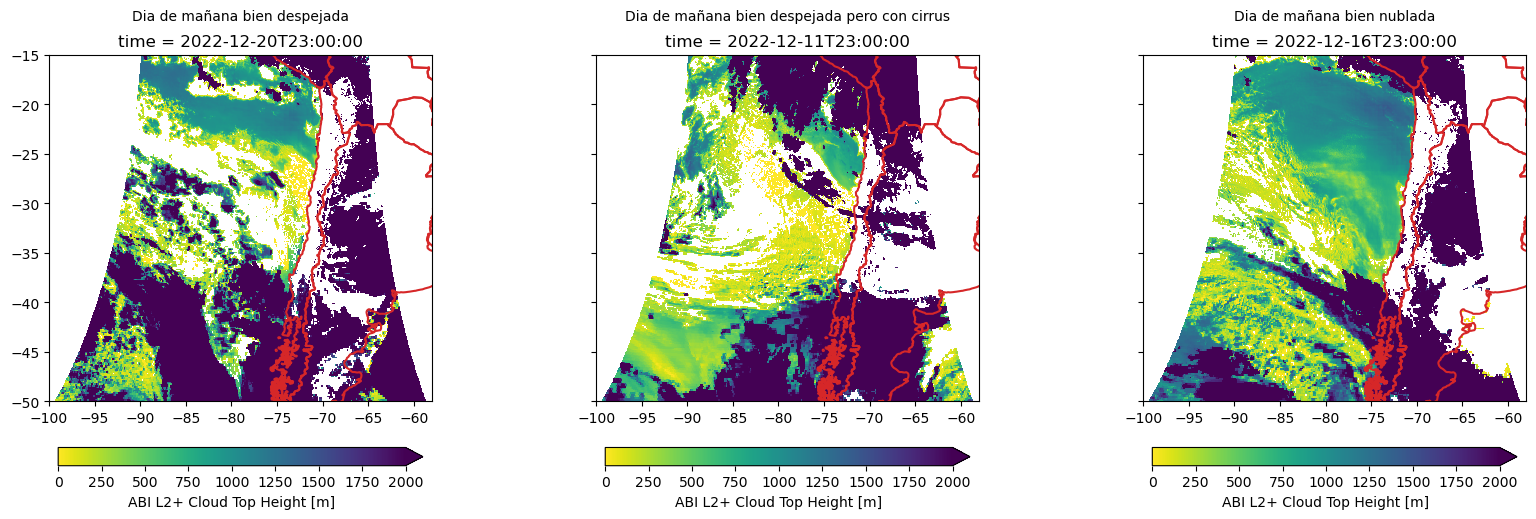

In [244]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,6))

cmap='viridis_r'
vmin,vmax=0,2000
data.sel(time="2022-12-20").HT[6*23].plot(y='lat',x='lon',vmin=vmin,vmax=vmax, cmap=cmap, ax=ax[0], cbar_kwargs={'orientation':'horizontal','pad':0.1, 'shrink':0.8}, add_labels=True)
data.sel(time="2022-12-11").HT[6*23].plot(y='lat',x='lon',vmin=vmin,vmax=vmax, cmap=cmap, ax=ax[1], cbar_kwargs={'orientation':'horizontal','pad':0.1, 'shrink':0.8}, add_labels=True)
data.sel(time="2022-12-16").HT[6*23].plot(y='lat',x='lon',vmin=vmin,vmax=vmax, cmap=cmap, ax=ax[2], cbar_kwargs={'orientation':'horizontal','pad':0.1, 'shrink':0.8}, add_labels=True)
for axis in ax.ravel():
    pass
    coastline.boundary.plot(ax=axis, color='tab:red')
    axis.set_xlim(-100,-58)
    axis.set_ylim(-50,-15)
    axis.set_ylabel('')
    axis.set_xlabel('')

ax[0].text(0.5,1.1,'Dia de mañana bien despejada', transform=ax[0].transAxes, ha='center')
ax[1].text(0.5,1.1,'Dia de mañana bien despejada pero con cirrus', transform=ax[1].transAxes, ha='center')
ax[2].text(0.5,1.1,'Dia de mañana bien nublada', transform=ax[2].transAxes, ha='center')